In [6]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow
import scipy.signal as sl
from typing import Optional
import scipy as sp
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout

from deepmeg.params import compute_temporal_parameters, compute_waveforms
from deepmeg.viz import plot_spatial_weights
import scipy as sp
from deepmeg.params import TemporalParameters, SpatialParameters, WaveForms, CompressionParameters, compute_compression_parameters
from collections import namedtuple

import sys
import os
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.models import SimpleNet, SimpleNetA


In [3]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
for c in cond:
    c['tmin'] = -.2
    c['tmax'] = .8
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
# times=np.ndarray(-.2, 1., 1/raw.info['sfreq'])
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
# print(epochs.info)
del raw

X = epochs.get_data()
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.load_data().pick_types(meg='grad').get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)

In [7]:
X.shape

(940, 204, 601)

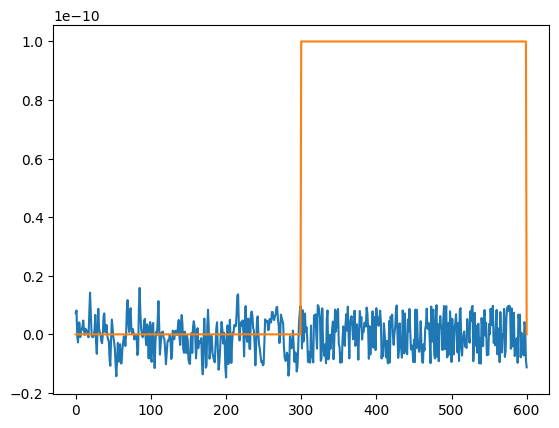

In [8]:
%matplotlib inline
start = 300
dist = 300
X_zeros = np.zeros_like(X)
X[:, :, start:start+dist] = 1*(2*1e-11*np.random.random((X.shape[0], X.shape[1], dist)) - 1e-11)
X_zeros[:, :, start:start+dist] += 1e-10*np.ones((X.shape[0], X.shape[1], dist))
X_zeros = X_zeros[0, 0]
plt.plot(X[0, 0])
plt.plot(X_zeros)

In [9]:
#Specify import options
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 30),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X: (940, 204, 601) targets: (940,)
(940,)
Preprocessing:
Scaling to interval 0.0 - 30.0
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 571, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 571, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


In [10]:
lf_params = dict(
    n_latent=8, #number of latent factors
    filter_length=75, #convolutional filter length in time samples
    nonlin = tf.nn.relu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3,
)

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 571, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 571, 8)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 571, 8)
Setting reg for fc, to l1
Built: fc input: (None, 1, 115, 8)
Input shape: (1, 571, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 6s - loss: 2.0660 - cat_ACC: 0.1563 - val_loss: 2.1080 - val_cat_ACC: 0.1349 - 6s/epoch - 58ms/step
Epoch 2/25
100/100 - 5s - loss: 1.9233 - cat_ACC: 0.2183 - val_loss: 1.9585 - val_cat_ACC: 0.1984 - 5s/epoch - 52ms/step
Epoch 3/25
100/100 - 5s - loss: 1.5698 - cat_ACC: 0.4021 - val_loss: 1.5992 - val_cat_ACC: 0.3730 - 5s/epoch - 51ms/step
Epoch 4/25
100/100 - 5s - loss: 1.1898 - cat_ACC: 0.5716 - val_loss: 1.3614 - val_cat_ACC: 0.4841 - 5s/epoch - 53ms/step
Epoch 5/25
100/100 - 5s - loss: 0.8860 - cat_ACC: 0.6884 - val_loss: 1.1797 - val_cat_ACC: 0.5635 - 5s/epoch - 54ms/step
Epoch 6/25
100/100 - 5s - loss: 0.6691 - cat

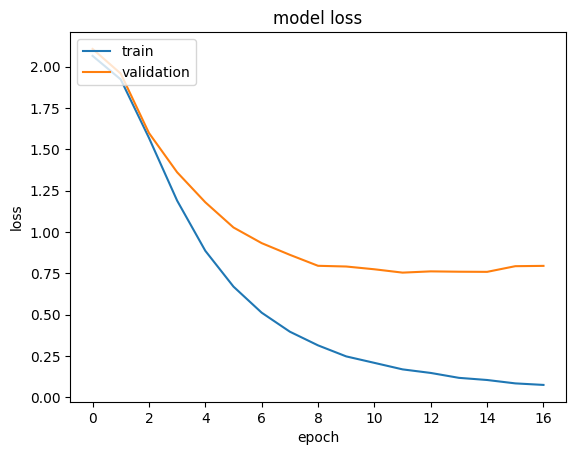

In [26]:
model = SimpleNet(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [27]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.692307710647583

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 571, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 571, 8)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 571, 8)
Setting reg for fc, to l1
Built: fc input: (None, 1, 114, 8)
Input shape: (1, 571, 204)
y_pred: (None, 8)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 7s - loss: 2.2643 - cat_ACC: 0.1603 - val_loss: 1.9285 - val_cat_ACC: 0.2256 - 7s/epoch - 73ms/step
Epoch 2/25
100/100 - 6s - loss: 1.4231 - cat_ACC: 0.4628 - val_loss: 1.1715 - val_cat_ACC: 0.5564 - 6s/epoch - 59ms/step
Epoch 3/25
100/100 - 5s - loss: 0.6352 - cat_ACC: 0.8090 - val_loss: 0.8136 - val_cat_ACC: 0.7519 - 5s/epoch - 51ms/step
Epoch 4/25
100/100 - 5s - loss: 0.3017 - cat_ACC: 0.9361 - val_loss: 0.7014 - val_cat_ACC: 0.7895 - 5s/epoch - 51ms/step
Epoch 5/25
100/100 - 6s - loss: 0.1584 - cat_ACC: 0.9802 - val_loss: 0.6463 - val_cat_ACC: 0.8120 - 6s/epoch - 57ms/step
Epoch 6/25
100/100 - 6s - loss: 0.0965 - cat

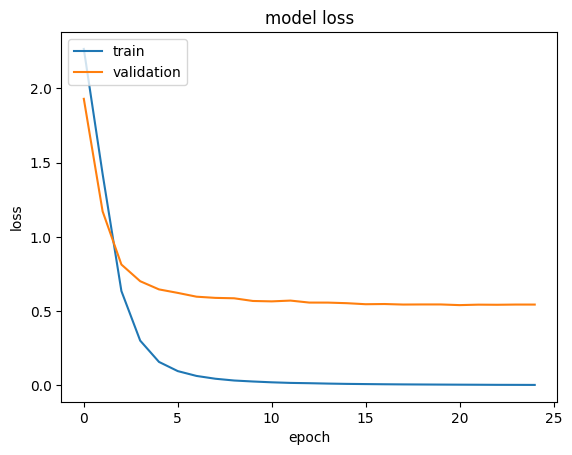

In [11]:
model = SimpleNetA(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [12]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.8269230723381042

In [13]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)
Processing branch 0...	DONE
Processing branch 1...	DONE
Processing branch 2...	DONE
Processing branch 3...	DONE
Processing branch 4...	DONE
Processing branch 5...	DONE
Processing branch 6...	DONE
Processing branch 7...	DONE


In [14]:
nt = model.dataset.h_params['n_t']
time_courses_filt = np.squeeze(model.lat_tcs_filt.reshape([model.specs['n_latent'], -1, nt]))
franges, finputs, foutputs, fresponces, fpatterns = compute_temporal_parameters(model)
induced, induced_filt, times, time_courses = compute_waveforms(model)

In [15]:
wf = WaveForms(time_courses.mean(1), time_courses_filt.mean(1), induced, induced_filt, times, time_courses)
sp_ = SpatialParameters(model.patterns, model.dmx.w.numpy())
tp = TemporalParameters(franges, finputs, foutputs, fresponces, fpatterns)

In [16]:
order = np.argsort(model.branch_relevance_loss)[::-1]

In [18]:
%matplotlib qt
plot_spatial_weights(
    sp_,
    tp,
    wf,
    epochs.info,
    summarize=order,
    logscale=False,
    temp_params=['input', 'output', 'response', 'pattern'],
    # shift_induced_times = -epochs.times[0],
    # filtered_induced=filt_induced
)
plt.show()

QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/viz.py:603: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if summarize == 'sum':
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/viz.py:605: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'sumabs':
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/viz.py:607: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'abssum':


In [17]:
temp_relevance_loss, eigencentrality_, time_courses_env, compression_weights = compute_compression_parameters(model)

cp = CompressionParameters(temp_relevance_loss, eigencentrality_, time_courses_env, compression_weights)

In [60]:
cp._fields

('loss_estimate', 'eig_estimate', 'envelopes', 'compression_weights')

In [84]:
del model

In [18]:
from deepmeg.params import save_parameters


save_parameters(order, '../dev/order.pkl')
save_parameters(sp_, '../dev/sp.pkl')
save_parameters(tp, '../dev/tp.pkl')
save_parameters(wf, '../dev/wf.pkl')
save_parameters(cp, '../dev/cf.pkl')

Saving  parameters...
Successfully saved
Saving  parameters...
Successfully saved
Saving  parameters...
Successfully saved
Saving  parameters...
Successfully saved
Saving  parameters...
Successfully saved


In [5]:
from deepmeg import read_pkl
order = read_pkl('../dev/order.pkl')
sp_ = read_pkl( '../dev/sp.pkl')
tp = read_pkl('../dev/tp.pkl')
wf = read_pkl('../dev/wf.pkl')
cp = read_pkl('../dev/cf.pkl')

AttributeError: Can't get attribute 'CroppingParameters' on <module 'deepmeg.params' from '/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/params.py'>

In [19]:
%matplotlib qt
from deepmeg.viz import plot_spatial_weights as plot_spatial_weights
plot_spatial_weights(
    sp_,
    tp,
    wf,
    epochs.info,
    cp,
    summarize='sumabs',
    logscale=False,
    temp_params=['input', 'output', 'response', 'pattern'],
    # shift_induced_times = -epochs.times[0],
    # filtered_induced=filt_induced
)
plt.show()

QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion


/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the 